# Loading Word Counts

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [88]:
import bz2
import os
import ujson
import attr
import re

import pandas as pd
import numpy as np
import statsmodels.api as sm

from glob import glob
from collections import Counter, UserDict
from itertools import islice
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

# Loading .npz vectors and metadata

In [3]:
count_npz = 'counts/novels.100.npz'

def load_all_counts(path):
    files = [os.path.join(path, f) 
             for f in os.listdir(path) 
             if f.endswith('.npz')]
    collected = {}
    for f in files:
        collected.update(np.load(f))
    return collected

In [168]:
md = pd.read_csv('metadata/novels-metadata-risinga-coefs.csv',
                 index_col='ix')
rising_a = md['coef'] > 0
rising_a_p05 = rising_a & (md['p'] < 0.05)
falling_a = md['coef'] < 0
falling_a_p05 = falling_a & (md['p'] < 0.05)
md = md.assign(rising_a=rising_a,
               rising_a_p05=rising_a_p05,
               falling_a=falling_a,
               falling_a_p05=falling_a_p05)
identifiers = set(md['identifier'])

In [169]:
rising_a.sum()

5096

In [170]:
features = load_all_counts(count_npz)
features = {k: v for k, v in features.items() if k in identifiers}
features = pd.DataFrame(cl).transpose()

# Constructing a cross-validation dataset

In [171]:
# pos_sel, = (md['falling_a'] == True).values.nonzero()
# neg_sel, = (md['falling_a'] == False).values.nonzero()
pos_sel, = (md['falling_a_p05'] == True).values.nonzero()
neg_sel, = (md['rising_a'] == True).values.nonzero()
n_cv_samples = 8000
np.random.seed(1000)
np.random.shuffle(pos_sel)
np.random.shuffle(neg_sel)
cvdata = np.hstack([pos_sel[0:n_cv_samples // 2], neg_sel[0:n_cv_samples // 2]])
np.random.shuffle(cvdata)
cvdata_md = md.iloc[cvdata]
cvdata_features = features.iloc[cvdata]

# Sanity check -- are labels correct?



----------------------
Regression for 'a' in 10156:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     4.684
Date:                Tue, 17 Apr 2018   Prob (F-statistic):             0.0441
Time:                        13:25:55   Log-Likelihood:                -83.590
No. Observations:                  20   AIC:                             171.2
Df Residuals:                      18   BIC:                             173.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

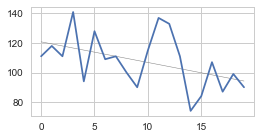

----------------------


----------------------
Regression for 'a' in AMFCF0002-C00000-B0924000:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     4.807
Date:                Tue, 17 Apr 2018   Prob (F-statistic):             0.0417
Time:                        13:25:55   Log-Likelihood:                -68.475
No. Observations:                  20   AIC:                             140.9
Df Residuals:                      18   BIC:                             142.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

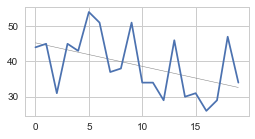

----------------------


----------------------
Regression for 'a' in AMFCF0002-C00000-B0616900:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     15.16
Date:                Tue, 17 Apr 2018   Prob (F-statistic):            0.00106
Time:                        13:25:56   Log-Likelihood:                -71.605
No. Observations:                  20   AIC:                             147.2
Df Residuals:                      18   BIC:                             149.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

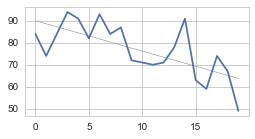

----------------------


----------------------
Regression for 'a' in 25857:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     8.517
Date:                Tue, 17 Apr 2018   Prob (F-statistic):            0.00917
Time:                        13:25:57   Log-Likelihood:                -87.037
No. Observations:                  20   AIC:                             178.1
Df Residuals:                      18   BIC:                             180.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

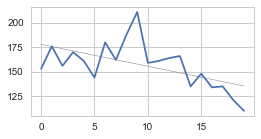

----------------------


----------------------
Regression for 'a' in AMFCF0002-C00000-B0339600:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     9.265
Date:                Tue, 17 Apr 2018   Prob (F-statistic):            0.00699
Time:                        13:25:58   Log-Likelihood:                -74.911
No. Observations:                  20   AIC:                             153.8
Df Residuals:                      18   BIC:                             155.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

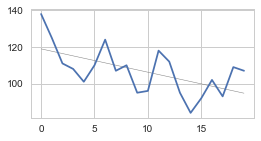

----------------------



In [172]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm_notebook(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

ds = Dataset('data/a-the-and-or.json/')
countmap = {
    novel['identifier']: np.array(novel['counts']['a'])
    for novel in ds.novels()
    if sum(novel['counts']['a'])
}

def lin_reg(counts):
    x = np.arange(len(counts))
    x = sm.add_constant(x)
    reg = sm.OLS(counts, x)
    return reg, reg.fit()

def plot_lin_reg(reg, fit):
    
    pred = fit.predict()
    x1 = reg.exog[0][1]
    x2 = reg.exog[-1][1]
    y1 = pred[0]
    y2 = pred[-1]
    
    plt.figure(figsize=(4,2))
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.plot(reg.endog)
    plt.show()

for ix in pos_sel[:5]:
    n_id = md.iloc[ix]['identifier']
    if n_id in countmap:
        c = countmap[n_id]
        reg, fit = lin_reg(c)
        print()
        print('----------------------')
        print('Regression for \'a\' in {}:'.format(n_id))
        print()
        print(fit.summary())
        print('Plot:')
        plot_lin_reg(reg, fit)
        print('----------------------')
        print()
    else:
        print()
        print('----------------------')
        print('{} not found in countmap?'.format(n_id))
        print('----------------------')
        print()


# Logistic regression (easy test)

In [173]:
n_features = 1000
n_train = len(cvdata_features) // 4 * 3
predict_key = 'corpus'
predict_val = 'chicago'

X = cvdata_features.iloc[:n_train].values[:, :n_features]
y = (cvdata_md.iloc[:n_train][predict_key] == predict_val).values.astype(float)
X_test = cvdata_features.iloc[n_train:].values[:, :n_features]
y_test = (cvdata_md.iloc[n_train:][predict_key] == predict_val).values.astype(float)

lr = LogisticRegression(C=1.0)
lr.fit(X, y)
lr.score(X_test, y_test)


0.654

# Logistic regression (real test)

In [174]:
n_features = 1000
n_train = len(cvdata_features) // 4 * 3
predict_key = 'falling_a'
predict_val = True

X = cvdata_features.iloc[:n_train].values[:, :n_features]
y = (cvdata_md.iloc[:n_train][predict_key] == predict_val).values.astype(float)
X_test = cvdata_features.iloc[n_train:].values[:, :n_features]
y_test = (cvdata_md.iloc[n_train:][predict_key] == predict_val).values.astype(float)

lr = LogisticRegression(C=1.0)
lr.fit(X, y)
lr.score(X_test, y_test)

0.488

# Support vector machine (easy test)

In [175]:
n_features = 1000
n_train = len(cvdata_features) // 4 * 3
predict_key = 'corpus'
predict_val = 'chicago'

X = cvdata_features.iloc[:n_train].values[:, :n_features]
y = (cvdata_md.iloc[:n_train][predict_key] == predict_val).values.astype(float)
X_test = cvdata_features.iloc[n_train:].values[:, :n_features]
y_test = (cvdata_md.iloc[n_train:][predict_key] == predict_val).values.astype(float)

lr = SVC(C=1.0)
lr.fit(X, y)
lr.score(X_test, y_test)

0.725

# Support vector machine (real test)

In [176]:
n_features = 1000
n_train = len(cvdata_features) // 4 * 3
predict_key = 'falling_a'
predict_val = True

X = cvdata_features.iloc[:n_train].values[:, :n_features]
y = (cvdata_md.iloc[:n_train][predict_key] == predict_val).values.astype(float)
X_test = cvdata_features.iloc[n_train:].values[:, :n_features]
y_test = (cvdata_md.iloc[n_train:][predict_key] == predict_val).values.astype(float)

lr = SVC(C=1.0)
lr.fit(X, y)
lr.score(X_test, y_test)

0.4945